In [1]:
import numpy as np
data=np.load('data_more.npy')
target=np.load('target_more.npy')

In [2]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D,Activation,MaxPooling2D
from tensorflow.keras.utils import normalize
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import Input
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow import keras
from tensorflow import lite

In [3]:

input_shape=data.shape[1:] #50,50,1
inp=Input(shape=input_shape)
convs=[]
#parrale 2d conv layer 128@3x3 128@5x5 128@7x7
parralel_kernels=[3,5,7]
for k in range(len(parralel_kernels)):

    conv = Conv2D(128,parralel_kernels[k],padding='same',activation='relu',input_shape=input_shape,strides=1)(inp)
    convs.append(conv)

out = Concatenate()(convs)
conv_model = Model(inputs=inp, outputs=out)

model = Sequential()
model.add(conv_model)

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
#use dropout for minimize overfitting
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

#use softmax as activiton of output layer since probability we need COVID19 & Negative
model.add(Dense(2,input_dim=128,activation='softmax'))

#categorical crossentropy use for specifictaion type problem
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 100, 100, 384)     11008     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 98, 98, 64)        221248    
_________________________________________________________________
activation (Activation)      (None, 98, 98, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 47, 32)        18464     
_________________________________________________________________
activation_1 (Activation)    (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0

In [5]:
from sklearn.model_selection import train_test_split
#as we see 10% testing go to testing and 90% go to the training 
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [7]:
#save all the nueral model here then moniter validation and then we save best only
#val-loss for minimum validation loss
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
#10 percent use as validation
#increasing epochs we increase the neural neural
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.1)


Epoch 1/20
23/23 [==============================] - 209s 9s/step - loss: 0.2155 - accuracy: 0.9264 - val_loss: 0.0816 - val_accuracy: 0.9747
Epoch 2/20
23/23 [==============================] - 187s 8s/step - loss: 0.1787 - accuracy: 0.9505 - val_loss: 0.0248 - val_accuracy: 1.0000
Epoch 3/20
23/23 [==============================] - 175s 8s/step - loss: 0.1310 - accuracy: 0.9562 - val_loss: 0.0433 - val_accuracy: 0.9873
Epoch 4/20
23/23 [==============================] - 220s 10s/step - loss: 0.1856 - accuracy: 0.9519 - val_loss: 0.0167 - val_accuracy: 1.0000
Epoch 5/20
23/23 [==============================] - 191s 8s/step - loss: 0.0998 - accuracy: 0.9675 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 6/20
23/23 [==============================] - 297s 13s/step - loss: 0.0418 - accuracy: 0.9873 - val_loss: 6.0034e-04 - val_accuracy: 1.0000
Epoch 7/20
23/23 [==============================] - 239s 10s/step - loss: 0.0930 - accuracy: 0.9731 - val_loss: 0.0118 - val_accuracy: 1.0000
Epoch 

In [8]:

keras_file="linear.h5"
tf.keras.models.save_model(model,keras_file)
converter=lite.TFLiteConverter.from_keras_model(model)
tfmodel=converter.convert()
open("linear.tflite","wb").write(tfmodel)




9708840

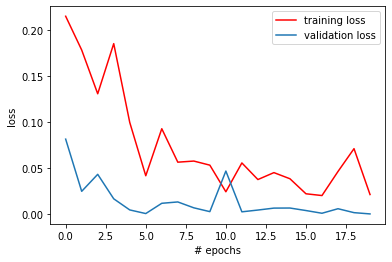

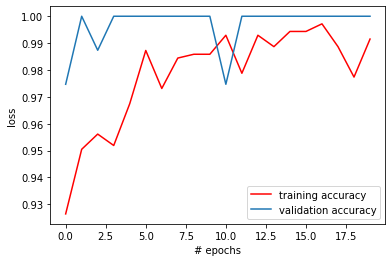

In [13]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [14]:
print(model.evaluate(test_data,test_target))

3/3 [==============================] - 4s 1s/step - loss: 0.2070 - accuracy: 0.9886
[0.20701517164707184, 0.9886363744735718]
